## Scaling Alternating Least Squares Using Apache SystemML

Recommendation systems based on Alternating Least Squares (ALS) algorithm have gained popularity in recent years because, in general, they perform better as compared to content based approaches.






ALS is a matrix factorization algorithm, where a user-item matrix is factorized into two low-rank non-orthogonal matrices:

$$R = U M$$

The elements, $r_{ij}$, of matrix $R$ can represent, for example, ratings assigned to the $j$th movie by the $i$th user.

This matrix factorization assumes that each user can be described by $k$ latent features. Similarly, each item/movie can also be represented by $k$ latent features. The user rating of a particular movie can thus be approximated by the product of two $k$-dimensional vectors:

$$r_{ij} = {\bf u}_i^T {\bf m}_j$$

The vectors ${\bf u}_i$ are rows of $U$ and ${\bf m}_j$'s are columns of $M$. These can be learned by minimizing the cost function:

$$f(U, M) = \sum_{i,j} \left( r_{ij} - {\bf u}_i^T {\bf m}_j \right)^2 = \| R - UM \|^2$$

###  Regularized ALS

In this notebook, we'll implement ALS algorithm with _weighted-$\lambda$-regularization_ formulated by [Zhou _et_. _al_](https://liuxiaofei.com.cn/blog/wp-content/uploads/2014/01/netflix_aaim08submitted.pdf). The cost function with such regularization is:

$$f(U, M) = \sum_{i,j} \left( r_{ij} - {\bf u}_i^T {\bf m}_j I_{ij} \right)^2 + \lambda \left( \sum_i n_{u_i} \| {\bf u}\|_i^2 + \sum_j n_{m_j} \|{\bf m}\|_j^2 \right)$$


Here, $\lambda$ is the usual regularization parameter. $n_{u_i}$ and $n_{m_j}$ represent the number of ratings of user $i$ and movie $j$ respectively. Deviating from the conventional notation, we're using $I_{ij}$ as an indicator variable such that $I_{ij} = 1$ if $r_{ij}$ exists and $I_{ij} = 0$ otherwise.

If we fix ${\bf m}_j$, we can determine ${\bf u}_i$ by solving a regularized least squares problem:

$$ \frac{1}{2} \frac{\partial f}{\partial {\bf u}_i} = 0$$

This gives the following matrix equation:

$$\left(M \text{diag}({\bf I}_i^T) M^{T} + \lambda n_{u_i} E\right) {\bf u}_i = M {\bf r}_i^T$$

Here ${\bf r}_i^T$ is the $i$th row of $R$. Similarly, ${\bf I}_i$ the $i$th row of the matrix $I = [I_{ij}]$. Please see [Zhou _et_. _al_](https://liuxiaofei.com.cn/blog/wp-content/uploads/2014/01/netflix_aaim08submitted.pdf) for details.

### Reading Netflix Movie Ratings Data

In this example, we'll use Netflix movie ratings. This data set can be downloaded from [here](http://academictorrents.com/details/9b13183dc4d60676b773c9e2cd6de5e5542cee9a). We'll use spark to read movie ratings data into a dataframe. The csv files have four columns: MovieID, UserID, Rating, Date.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from systemml import MLContext, dml

spark = SparkSession\
        .builder\
        .appName("als-example")\
        .getOrCreate()

In [2]:
schema = StructType([StructField("movieId", IntegerType(), True),
                     StructField("userId", IntegerType(), True),
                     StructField("rating", IntegerType(), True),
                     StructField("date", StringType(), True)])

In [3]:
ratings = spark.read.csv("./netflix/training_set_normalized/mv_0*.txt", schema = schema)
ratings = ratings.select('userId', 'movieId', 'rating')
ratings.show(10)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
| 53679|   5317|     4|
| 29545|   5317|     3|
| 41412|   5317|     3|
| 28213|   5317|     3|
| 30878|   5317|     3|
| 56069|   5317|     3|
| 49479|   5317|     4|
| 42362|   5317|     2|
| 43601|   5317|     4|
| 45276|   5317|     3|
+------+-------+------+
only showing top 10 rows



In [4]:
ratings.describe().show()

+-------+------------------+------------------+------------------+
|summary|            userId|           movieId|            rating|
+-------+------------------+------------------+------------------+
|  count|           2268082|           2268082|           2268082|
|   mean|30028.841485008037| 9068.777048625227|3.6134694424628386|
| stddev| 17290.49124532639|5131.8304910232055|1.0810520483121464|
|    min|                 6|                 1|                 1|
|    max|             59999|             17770|                 5|
+-------+------------------+------------------+------------------+



### ALS implementation using DML

The following script implements the regularized ALS algorithm as described above. One thing to note here is that we remove empty rows/columns from the rating matrix before running the algorithm. We'll add back the zero rows and columns to matrices $U$ and $M$ after the algorithm converges.

In [5]:
#-----------------------------------------------------------------
# Create kernel in SystemML's DSL using the R-like syntax for ALS
# Algorithms available at : https://systemml.apache.org/algorithms
# Below algorithm based on ALS-CG.dml
#-----------------------------------------------------------------
als_dml = \
"""
# Default values of some parameters
r          = rank
max_iter   = 50
check      = TRUE
thr        = 0.0001

R = table(X[,1], X[,2], X[,3])

# check the input matrix R, if some rows or columns contain only zeros remove them from R
R_nonzero_ind = R != 0;
row_nonzeros = rowSums(R_nonzero_ind);
col_nonzeros = t(colSums (R_nonzero_ind));
orig_nonzero_rows_ind = row_nonzeros != 0;
orig_nonzero_cols_ind = col_nonzeros != 0;
num_zero_rows = nrow(R) - sum(orig_nonzero_rows_ind);
num_zero_cols = ncol(R) - sum(orig_nonzero_cols_ind);
if (num_zero_rows > 0) {
  print("Matrix R contains empty rows! These rows will be removed.");
  R = removeEmpty(target = R, margin = "rows");
}
if (num_zero_cols > 0) {
  print ("Matrix R contains empty columns! These columns will be removed.");
  R = removeEmpty(target = R, margin = "cols");
}
if (num_zero_rows > 0 | num_zero_cols > 0) {
  print("Recomputing nonzero rows and columns!");
  R_nonzero_ind = R != 0;
  row_nonzeros = rowSums(R_nonzero_ind);
  col_nonzeros = t(colSums (R_nonzero_ind));
}

###### MAIN PART ######

m = nrow(R);
n = ncol(R);

# initializing factor matrices
U = rand(rows = m, cols = r, min = -0.5, max = 0.5);
M = rand(rows = n, cols = r, min = -0.5, max = 0.5);

# initializing transformed matrices
Rt = t(R);


loss_init = 0.0; # only used if check is TRUE
if (check) {
  loss_init = sum(R_nonzero_ind * (R - (U %*% t(M)))^2) + lambda * (sum((U^2) * row_nonzeros) + sum((M^2) * col_nonzeros));
  print("----- Initial train loss: " + loss_init + " -----");
}

lambda_I = diag (matrix (lambda, rows = r, cols = 1));
it = 0;
converged = FALSE;
while ((it < max_iter) & (!converged)) {
  it = it + 1;
  # keep M fixed and update U
  parfor (i in 1:m) {
    M_nonzero_ind = t(R[i,] != 0);
    M_nonzero = removeEmpty(target=M * M_nonzero_ind, margin="rows");
    A1 = (t(M_nonzero) %*% M_nonzero) + (as.scalar(row_nonzeros[i,1]) * lambda_I); # coefficient matrix
    U[i,] = t(solve(A1, t(R[i,] %*% M)));
  }

  # keep U fixed and update M
  parfor (j in 1:n) {
    U_nonzero_ind = t(Rt[j,] != 0)
    U_nonzero = removeEmpty(target=U * U_nonzero_ind, margin="rows");
    A2 = (t(U_nonzero) %*% U_nonzero) + (as.scalar(col_nonzeros[j,1]) * lambda_I); # coefficient matrix
    M[j,] = t(solve(A2, t(Rt[j,] %*% U)));
  }

  # check for convergence
  if (check) {
    loss_cur = sum(R_nonzero_ind * (R - (U %*% t(M)))^2) + lambda * (sum((U^2) * row_nonzeros) + sum((M^2) * col_nonzeros));
    loss_dec = (loss_init - loss_cur) / loss_init;
    print("Train loss at iteration (M) " + it + ": " + loss_cur + " loss-dec " + loss_dec);
    if (loss_dec >= 0 & loss_dec < thr | loss_init == 0) {
      print("----- ALS converged after " + it + " iterations!");
      converged = TRUE;
    }
    loss_init = loss_cur;
    print(loss_init)
  }
} # end of while loop

if (check) {
  print("----- Final train loss: " + loss_init + " -----");
}

if (!converged) {
  print("Max iteration achieved but not converged!");
}

# inject 0s in U if original R had empty rows
if (num_zero_rows > 0) {
  U = removeEmpty(target = diag(orig_nonzero_rows_ind), margin = "cols") %*% U;
}
# inject 0s in R if original V had empty rows
if (num_zero_cols > 0) {
  M = removeEmpty(target = diag(orig_nonzero_cols_ind), margin = "cols") %*% M;
}
M = t(M);
"""

### Running the Algorithm

We'll first create an MLContext object which the entry point for SystemML. Inputs and outputs are defined through a dml function.

In [6]:
ml = MLContext(sc)

# Define input/output variables for DML script
alsScript = dml(als_dml).input("X", ratings)        \
                        .input("lambda", 0.1)       \
                        .input("rank", 15)          \
                        .output("U", "M")
            
# Execute script
res = ml.execute(alsScript)
U, M = res.get('U','M')

### Predictions


Once $U$ and $M$ are learned from the data, we can recommend movies for any users. If $U'$ represent the users for which we seek recommendations, we first obtain the predicted ratings for all the movies by users in $U'$:

$$R' = U' M$$

Finally, we sort the ratings for each user and present the top 5 movies with highest predicted ratings. The following dml script implements this. Since we're using very low rank in this example, these recommendations are not meaningful.

In [7]:
predict_dml = \
"""
R = table(R[,1], R[,2], R[,3])
K = 5
Rrows = nrow(R);
Rcols = ncol(R);

zero_cols_ind = (colSums(M != 0)) == 0;
K = min(Vcols - sum(zero_cols_ind), K);

n = nrow(X);

Urows = nrow(U);
Mcols = ncol(M);

X_user_max = max(X[,1]);

if (X_user_max > Rrows) {
	stop("Predictions cannot be provided. Maximum user-id exceeds the number of rows of R.");
}
if (Urows != Rrows | Mcols !=  Rcols) {
	stop("Number of rows of U (columns of M) does not match the number of rows (column) of R.");
}

# creats projection matrix to select users
s = seq(1, n);
ones = matrix(1, rows = n, cols = 1);
P = table(s, X[,1], ones, n, Urows);


# selects users from factor U
U_prime = P %*% U;

# calculate rating matrix for selected users
R_prime = U_prime %*% M;

# selects users from original R
R_users = P %*% R;

# create indictor matrix to remove existing ratings for given users
I = R_users == 0;

# removes already recommended items and creating user2item matrix
R_prime = R_prime * I;

# stores sorted movies for selected users 
R_top_indices = matrix(0, rows = nrow (R_prime), cols = K);
R_top_values = matrix(0, rows = nrow (R_prime), cols = K);

# a large number to mask the max ratings
range = max(R_prime) - min(R_prime) + 1;

# uses rowIndexMax/rowMaxs to update kth ratings
for (i in 1:K){
	rowIndexMax = rowIndexMax(R_prime);
	rowMaxs = rowMaxs(R_prime);
	R_top_indices[,i] = rowIndexMax;
	R_top_values[,i] = rowMaxs;
	R_prime = R_prime - range * table(seq (1, nrow(R_prime), 1), rowIndexMax, nrow(R_prime), ncol(R_prime));
}

R_top_indices = R_top_indices * (R_top_values > 0);

# cbind users as a first column
R_top_indices = cbind(X[,1], R_top_indices);
R_top_values = cbind(X[,1], R_top_values);
"""

In [8]:
# user for which we want to recommend movies
ids = [53679,29545,41412,28213,30878,56069,49479,42362,43601,45276]
users = spark.createDataFrame([[i] for i in ids])

predScript = dml(predict_dml).input("R", ratings)  \
                             .input("X", users)    \
                             .input("U", U)        \
                             .input("M", M)        \
                             .output("R_top_indices")

pred = ml.execute(predScript).get("R_top_indices")

pred = pred.toNumPy()

### Just for Fun!

Once we have the movie recommendations, we can show the movie posters for those recommendations. We'll fetch these movie poster from wikipedia. If movie page doesn't exist on wikipedia, we'll just list the movie title.

In [9]:
import pandas as pd
titles = pd.read_csv("./netflix/movie_titles.csv", header=None, sep=';', names=['movieID', 'year', 'title'])

In [10]:
import re
import wikipedia as wiki
from bs4 import BeautifulSoup as bs
import requests as rq
from IPython.core.display import Image, display

In [11]:
def get_poster(title):
    if title.endswith('Bonus Material'):
        title = title.strip('Bonus Material')
        
    title = re.sub(r'[^\w\s]','',title)
    matches = wiki.search(title)
    film = [s for s in matches if 'film)' in s]
    film = film[0] if len(film) > 0 else matches[0]

    try:
        url = wiki.page(film).url
    except:
        return

    html = rq.get(url)
    if html.status_code == 200:
        soup = bs(html.content, 'html.parser')
        infobox = soup.find('table', class_="infobox")
        if (infobox):
            img = infobox.find('img')
            if img:
                display(Image('http:' + img['src']))

In [12]:
def show_recommendations(userId, preds):
    for row in preds:
        if int(row[0]) == userId:
            print("\nrecommendations for userId", int(row[0]) )
            for title in titles.title[row[1:]].values:
                print(title)
                get_poster(title)
            break


recommendations for userId 41412
Call of the Wild


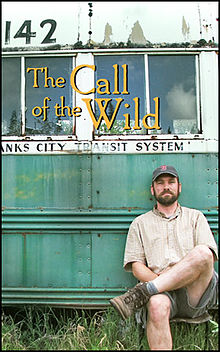

Colors Straight Up


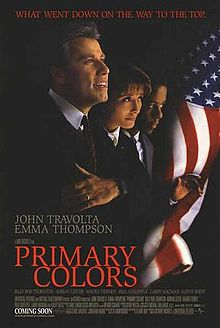

The Jack Paar Collection
The Color of Money


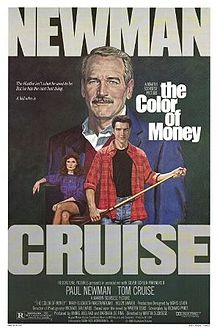

Don Juan De Marco


In [13]:
show_recommendations(41412, preds=pred)